20newsgroups data fetched from sklearn for clustering or classification task

In [1]:
import re
import sklearn
import pandas as pd
import numpy as np
import sklearn.ensemble
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from io import StringIO
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

from sklearn.datasets import fetch_20newsgroups

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import matplotlib.pyplot as plt
import seaborn as sns

import eli5
from eli5.lime import TextExplainer
from sklearn.metrics import accuracy_score

from gensim import models 
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from tqdm import tqdm

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
test = fetch_20newsgroups(subset='test',remove=('headers', 'footers', 'quotes'))

/opt/anaconda3/envs/dw_xai_nlp/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/envs/dw_xai_nlp/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/weronikadranka/nltk_data...
[nltk_data]   Package stopword

In [2]:
from text_prepare import html_docode, clean_text, stemm_text, lemmatize_text

## Data preparation

In [27]:
#Can we train a word2vec on it??
def clean_sentences(text):
    """Remove posting header, split by sentences and words, keep only letters"""
    lines = re.split('[?!.:]\s', re.sub('^.*Lines: \d+', '', re.sub('\n', ' ', text)))
    return [re.sub('[^a-zA-Z]', ' ', line).lower().split() for line in lines]

sentences = [line for text in newsgroups_train.data for line in clean_sentences(text)]
num_classess=len(np.unique(newsgroups_train.target))

model = models.Word2Vec(sentences, workers=4, size=100, min_count=50, window=10, sample=1e-3)

print (model.wv.most_similar('memory'))

[('cpu', 0.8914265632629395), ('video', 0.8485193848609924), ('monitor', 0.8479585647583008), ('cache', 0.8396305441856384), ('vga', 0.8255327343940735), ('ram', 0.8237516283988953), ('disk', 0.8231228590011597), ('upgrade', 0.8185527324676514), ('mode', 0.8156496286392212), ('meg', 0.8143798112869263)]


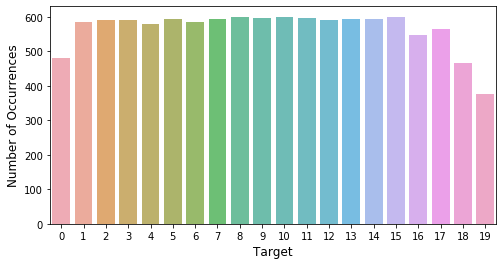

In [3]:
#how data is distibuted
df_dict = {'data' : newsgroups_train.data, 'target' : newsgroups_train.target}
df_news_train =pd.DataFrame(df_dict)
count_target = df_news_train['target'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(count_target.index, count_target.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target', fontsize=12);

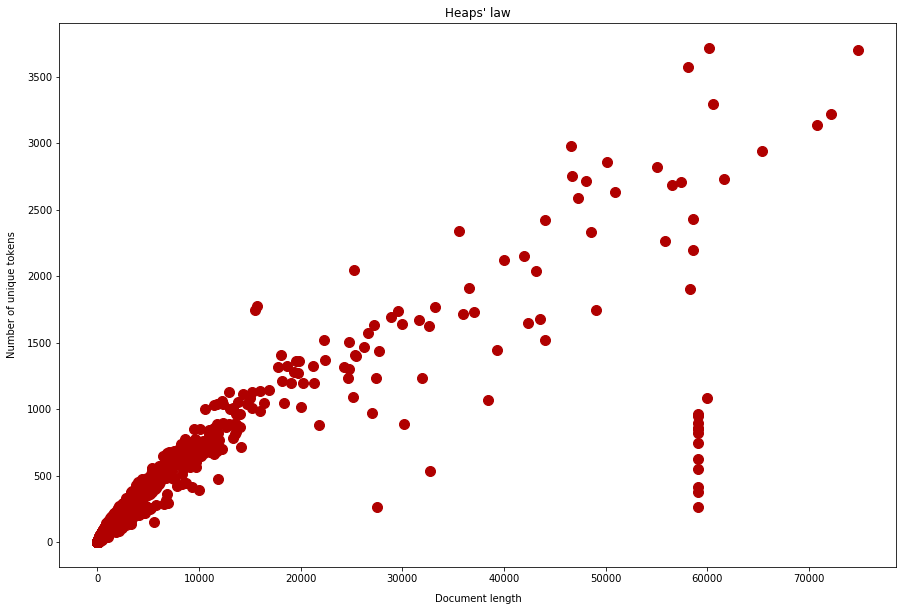

[144, 1492, 1506, 1541, 3198, 4090, 4495, 4515, 4772, 8213, 8665, 9080, 10275]

In [3]:
#are there any outliers
COLOR = (176/255, 0, 0)
FIGSIZE = (15, 10)
LINEWIDTH = 5
LABELPAD = 10

def draw_heaps_plot(
        texts,
        ax=None):

    lengths = [len(t) for t in texts]
    num_uniques = [len(set(t.split())) for t in texts]
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    else:
        fig = None
    
    ax.scatter(lengths, num_uniques, s=4 * LINEWIDTH ** 2, color=COLOR)
    
    ax.set_xlabel('Document length', labelpad=LABELPAD)
    ax.set_ylabel('Number of unique tokens', labelpad=LABELPAD)
    ax.set_title('Heaps\' law')
    
    if fig is not None:
        plt.show()

    return ax

draw_heaps_plot(newsgroups_train.data)
lengths = [len(t) for t in newsgroups_train.data]
num_uniques = [len(set(t.split())) for t in newsgroups_train.data]

#Remove those strange things
suspicious_indices = [i for i, l in enumerate(lengths) if l >= 58000 and l <= 60000 and num_uniques[i] < 1500]
newsgroups_train.data = [art for (i,art) in enumerate(newsgroups_train.data) if i not in suspicious_indices]
newsgroups_train.target = [target for (i,target) in enumerate(newsgroups_train.target) if i not in suspicious_indices]

suspicious_indices

In [4]:
#Clean text and lemmatize it
html_decoded = html_docode(newsgroups_train.data)
cleaned_news = clean_text(html_decoded)
lemmatized_news = lemmatize_text(cleaned_news)

html_decoded_test = clean_text(test.data)
cleaned_test = clean_text(html_decoded_test)
lemmatized_test = lemmatize_text(cleaned_test)

/Users/weronikadranka/Documents/DW/text_prepare.py:8: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 8 of the file /Users/weronikadranka/Documents/DW/text_prepare.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  return [BeautifulSoup(article, "html").text for article in text]# HTML decoding. BeautifulSoup's text attribute will return a string stripped of any HTML tags and metadata.


In [5]:
#Conver to dataframes
data_train = pd.DataFrame({"news" :lemmatized_news, "target" : newsgroups_train.target})
print(data_train.head())

data_test = pd.DataFrame({"news" :lemmatized_test, "target" : test.target})
print(data_test.head())

                                                news  target
0  wondering anyone could enlighten door sport lo...       7
1  fair number brave soul upgraded clock oscillat...       4
2  well folk plus finally gave ghost weekend star...       4
3  weiteks address phone number like information ...       1
4  article tombaker worldstdcom baker understandi...      14
                                                news  target
0  little confused model bonnevilles heard ssei c...       7
1  familiar format xface thingies seeing folk hea...       5
2                                               word       0
3  attacking iraqi drive kuwait country whose cit...      17
4  spent solid month arguing thing objective mora...      19


In [6]:
#Remove empty news
len_list_train = [len(text['news'].split()) for idx, text in data_train.iterrows()]
zero_indices_train = [idx for idx, length in enumerate(len_list_train) if length<=1]
len_list_test = [len(text['news'].split()) for idx, text in data_test.iterrows()]
zero_indices_test = [idx for idx, length in enumerate(len_list_test) if length<=1]

data_train = data_train.drop(zero_indices_train)
data_train = data_train.reset_index(drop=True)

data_test = data_test.drop(zero_indices_test)
data_test = data_test.reset_index(drop=True)

frames = [data_train, data_test]
data_whole = pd.concat(frames, ignore_index=True)

In [8]:
len(data_train)

10919

In [9]:
len(data_whole)

18173

## Supervised classification- SVC, SGD

In [11]:
#Train some classifiers and try it out
text_clf_svc = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(C=150, gamma=1e-2, probability=True, kernel="rbf"))])
    
text_clf_svc.fit(data_train['news'], data_train['target'])

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 SVC(C=150, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,

In [12]:
print("Accuracy: {:.1%}".format(text_clf_svc.score(data_train['news'], data_train['target'])))

Accuracy: 99.8%


In [13]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])
text_clf.fit(data_train['news'], data_train['target'])

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [14]:
print("Accuracy: {:.1%}".format(text_clf.score(data_train['news'], data_train['target'])))

Accuracy: 93.0%


In [15]:
predicted = text_clf.predict(data_test['news'])
np.mean(predicted ==  data_test['target'])

0.684449958643507

In [16]:
predicted = text_clf_svc.predict(data_test['news'])
np.mean(predicted == data_test['target'])

0.6621174524400331

In [17]:
#Show feature importance for each class
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: %s" % (category, " ".join(feature_names[top10])))

show_top10(text_clf['clf'], text_clf['vect'], newsgroups_train.target_names)

alt.atheism: islamic sank beauchaine bobbe viceicotekcom motto islam bobby atheist atheism
comp.graphics: surface algorithm viewer format animation cview tiff polygon graphic image
comp.os.ms-windows.misc: icon truetype desktop microsoft ftpcicaindianaedu driver font file cica window
comp.sys.ibm.pc.hardware: setting orchid harddisk motherboard adaptec bios gateway jumper scsi controller
comp.sys.mac.hardware: mac lciii powerbook iisi vram nubus simms quadra centris apple
comp.windows.x: contrib pixmap colormap xlib openwindows client xterm server motif widget
misc.forsale: interested excellent includes manual sell asking condition offer shipping sale
rec.autos: taurus engine saturn auto toyota wagon convertible dealer ford car
rec.motorcycles: biker kawasaki countersteering harley rider riding helmet ride motorcycle bike
rec.sport.baseball: yankee cub alomar run phillies hitter brave baseball pitcher pitching
rec.sport.hockey: islander pen game espn detroit goal leaf team playoff hock

In [24]:
#Choose one sample to explain it with model agnositc method - LIME
i = 100
print("Class: {}".format(newsgroups_train.target_names[data_test['target'][i]]))
print("-"*20); print()
sample = data_test['news'][i]
print(sample)

Class: comp.sys.ibm.pc.hardware
--------------------

computer sheridan college file would like make read used attrib command people carry around attrib program pocket still able erase important file software package would make entire drive readonly example partition drive partition first drive contain important file read second drive could read write enquiry help would appreciated


In [25]:
pred = text_clf_svc.predict([sample])
newsgroups_train.target_names[pred[0]]

'comp.sys.ibm.pc.hardware'

In [26]:
#Do some explnations with eli5
te = TextExplainer(random_state=42)
te.fit(sample, text_clf_svc.predict_proba)
te.show_prediction(target_names=newsgroups_train.target_names)

# Implementing various metrics to compute similarity.

1. Cosine
2. Euclidean
3. Jaccard
4. Word Mover

## Cosine


In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

count_vec = CountVectorizer(min_df = 5, max_df=0.50)
#count_vec = TfidfVectorizer()
count_matrix = count_vec.fit_transform(data_whole["news"])
feature_names = count_vec.get_feature_names()

In [29]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim)

[[1.         0.04116935 0.1278724  ... 0.03952847 0.13135266 0.05345225]
 [0.04116935 1.         0.0478584  ... 0.01627361 0.06180232 0.        ]
 [0.1278724  0.0478584  1.         ... 0.04595091 0.10470471 0.09941916]
 ...
 [0.03952847 0.01627361 0.04595091 ... 1.         0.01483477 0.04225771]
 [0.13135266 0.06180232 0.10470471 ... 0.01483477 1.         0.16048217]
 [0.05345225 0.         0.09941916 ... 0.04225771 0.16048217 1.        ]]


In [34]:
test_id = 1
k_neighbors = 10
similarity_matrix = cosine_sim
test_ids = [2,3,4,5,6,7,8]

In [35]:
def get_k_neighbors_classes(test_id, similarity_matrix, k_neighbors, ascending_metric = True):
    # move to docstring: if distance is used - the bigger distance the more dissimilar samples - sort Ascendng (get small values)
    # if we are using similarity we want to have the highest score first - sored descending (set parameter to false)
    neares_neis = []
    score_series = pd.Series(similarity_matrix[test_id]).sort_values(ascending = ascending_metric)
    top_indices = list(score_series.iloc[1:k_neighbors+1].index)
    top_scores = list(score_series.iloc[1:k_neighbors+1])
    for i, s in zip(top_indices, top_scores):
        neares_neis.append((i, list(data_whole['target'])[i], s))
    #TODO remove that data[target]
    return (neares_neis)

def predict_classification(test_id, similarity_matrix, k_neighbors, ascending_metric = True):
    neighbors = get_k_neighbors_classes(test_id, similarity_matrix, k_neighbors, ascending_metric)
    neighbors_classes = [x[1] for x in neighbors]
    prediction = max(set(neighbors_classes), key=neighbors_classes.count)
    return prediction

In [ ]:
predicted_labls_cosine =[]
for i, _ in tqdm(data_whole.iterrows()):
    predicted_labls_cosine.append(predict_classification(i, cosine_sim, k_neighbors, ascending_metric = False))
  

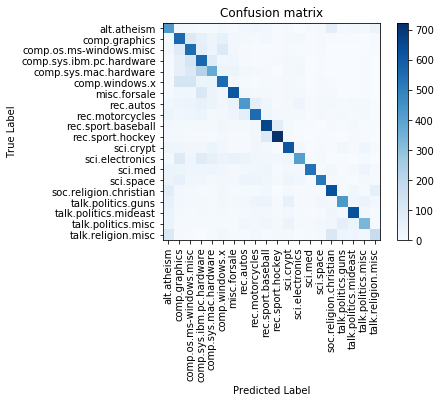

In [46]:
from sklearn import metrics
# Plot information 
def plot_confusion_matrix(cm, 
                          true_classes,
                          pred_classess,
                          title = ''):
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    xtick_marks = np.arange(len(pred_classess))
    ytick_marks = np.arange(len(true_classes))
    plt.xticks(xtick_marks, pred_classess, rotation = 90)
    plt.yticks(ytick_marks, true_classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
cm = metrics.confusion_matrix(data_whole['target'], predicted_labls_cosine)
plt.figure()
plot_confusion_matrix(cm, 
                      true_classes = newsgroups_train.target_names,
                      pred_classess = newsgroups_train.target_names,
                      title = 'Confusion matrix')

In [48]:
print(metrics.classification_report(data_whole['target'], predicted_labls_cosine,
                            target_names=newsgroups_train.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.41      0.55      0.47       773
           comp.graphics       0.43      0.60      0.50       943
 comp.os.ms-windows.misc       0.43      0.60      0.50       928
comp.sys.ibm.pc.hardware       0.41      0.59      0.48       961
   comp.sys.mac.hardware       0.43      0.41      0.42       921
          comp.windows.x       0.51      0.57      0.54       971
            misc.forsale       0.62      0.65      0.63       955
               rec.autos       0.54      0.47      0.50       924
         rec.motorcycles       0.58      0.58      0.58       959
      rec.sport.baseball       0.60      0.70      0.65       941
        rec.sport.hockey       0.77      0.75      0.76       968
               sci.crypt       0.63      0.64      0.64       957
         sci.electronics       0.64      0.43      0.52       951
                 sci.med       0.86      0.57      0.68       954
         

In [49]:
# kNN Algorithm whole process even with vectorizing
def k_nearest_neighbors_cosine(data, test_ids, k_neighbors):
    vec = CountVectorizer()
    #vec = TfidfVectorizer()
    count_matrix = vec.fit_transform(data)
    cosine_sim = cosine_similarity(count_matrix, count_matrix)
    
    predictions = list()
    for test_id in test_ids:
        output = predict_classification(test_id, cosine_sim, k_neighbors, ascending_metric = False)
        predictions.append(output)
    return(predictions)


print(k_nearest_neighbors_cosine(data_whole["news"], test_ids, k_neighbors))

[3, 1, 5, 16, 3, 3, 2]


In [50]:
data_whole["target"][test_ids]

2     4
3     1
4    14
5    16
6    13
7     3
8     2
Name: target, dtype: int64

In [74]:
def explain_recommendation(test_id, data, neighbors, feature_names, count_matrix):
    key_words = {}
    key_words['test_sample_class'] = data['target'][test_id]
    title_key_words_dense = count_matrix[test_id].todense().tolist()[0]
    for idx_recommended, _, _ in neighbors:
        scores = [a*b for (a,b) in zip(title_key_words_dense, count_matrix[idx_recommended].todense().tolist()[0])]
        key_words[idx_recommended] = {}
        key_words[idx_recommended]['neighbour_class'] = data['target'][idx_recommended]
        key_words[idx_recommended]['important_words'] = []
        for index, value in enumerate(scores):
            if value != 0:
                key_words[idx_recommended]['important_words'].append((feature_names[index],value))
    return key_words

In [65]:
data_whole['target'][test_id]

4

In [66]:
neighbors = get_k_neighbors_classes(test_id, similarity_matrix, k_neighbors, False)
neighbors_classes = [x[1] for x in neighbors]
prediction = max(set(neighbors_classes), key=neighbors_classes.count)

In [67]:
neighbors

[(6171, 4, 0.3784446313307283),
 (8806, 4, 0.32677157314697547),
 (14817, 4, 0.28919252192030875),
 (16349, 4, 0.28607725128818),
 (12323, 4, 0.265747001726367),
 (14320, 5, 0.26037782196164777),
 (11895, 5, 0.26037782196164777),
 (6528, 4, 0.2564023545856837),
 (9576, 4, 0.23231373170253145),
 (12644, 12, 0.2254938084008487)]

In [68]:
predict_classification(test_id, similarity_matrix, k_neighbors, False)

4

In [75]:
explain_recommendation(test_id, data_whole, neighbors, feature_names, count_matrix)

{'test_sample_class': 4,
 6171: {'neighbour_class': 4,
  'important_words': [('card', 1),
   ('clock', 2),
   ('disk', 1),
   ('experience', 2),
   ('floppy', 2),
   ('functionality', 1),
   ('heat', 1),
   ('hour', 1),
   ('number', 1),
   ('oscillator', 1),
   ('please', 4),
   ('procedure', 1),
   ('sink', 1),
   ('speed', 6),
   ('upgrade', 1)]},
 8806: {'neighbour_class': 4,
  'important_words': [('brave', 1),
   ('clock', 6),
   ('floppy', 4),
   ('oscillator', 1),
   ('soul', 1),
   ('speed', 8)]},
 14817: {'neighbour_class': 4,
  'important_words': [('adapter', 8),
   ('card', 10),
   ('clock', 8),
   ('disk', 2),
   ('floppy', 10),
   ('heat', 17),
   ('hour', 4),
   ('number', 1),
   ('oscillator', 3),
   ('poll', 4),
   ('rated', 2),
   ('sink', 17),
   ('speed', 16),
   ('thanks', 1),
   ('upgrade', 1)]},
 16349: {'neighbour_class': 4,
  'important_words': [('clock', 2),
   ('havent', 1),
   ('oscillator', 2),
   ('please', 2),
   ('speed', 6)]},
 12323: {'neighbour_class':

## Euclidean

In [76]:
from sklearn.metrics.pairwise import euclidean_distances

In [77]:
# vec = CountVectorizer(min_df=5, max_df=0.5)
vec = TfidfVectorizer()
count_matrix = vec.fit_transform(data_whole["news"])
feature_names = np.asarray(vec.get_feature_names())

In [78]:
def k_nearest_neighbors_euclid(data, test_ids, k_neighbors):
    #vec = CountVectorizer(min_df=5, max_df=0.5)
    vec = TfidfVectorizer()
    count_matrix = vec.fit_transform(data)
    euclidean_dist = euclidean_distances(count_matrix, count_matrix)
    predictions = list()
    for test_id in test_ids:
        output = predict_classification(test_id, euclidean_dist, k_neighbors)
        predictions.append(output)
    return(predictions)

In [79]:
euclidean_dist = euclidean_distances(count_matrix, count_matrix)

test_id = 1
k_neighbors = 10
similarity_matrix = euclidean_dist
test_ids = [2,3,4,5,6,7,8]

In [89]:
predict_classification(test_id, euclidean_dist, k_neighbors)

4

In [ ]:
predicted_labls_euclid = []
for i, _ in tqdm(data_whole.iterrows()):
    predicted_labls_euclid.append(predict_classification(i, similarity_matrix, k_neighbors))

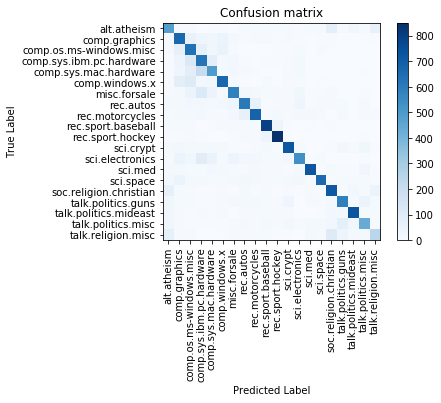

In [93]:
cm = metrics.confusion_matrix(data_whole['target'], predicted_labls_euclid)
plt.figure()
plot_confusion_matrix(cm, 
                      true_classes = newsgroups_train.target_names,
                      pred_classess = newsgroups_train.target_names,
                      title = 'Confusion matrix')

In [94]:
print(metrics.classification_report(data_whole['target'], predicted_labls_euclid,
                            target_names=newsgroups_train.target_names))


                          precision    recall  f1-score   support

             alt.atheism       0.56      0.62      0.59       773
           comp.graphics       0.57      0.70      0.63       943
 comp.os.ms-windows.misc       0.51      0.69      0.59       928
comp.sys.ibm.pc.hardware       0.48      0.65      0.56       961
   comp.sys.mac.hardware       0.56      0.54      0.55       921
          comp.windows.x       0.70      0.69      0.70       971
            misc.forsale       0.68      0.61      0.64       955
               rec.autos       0.70      0.66      0.68       924
         rec.motorcycles       0.74      0.71      0.73       959
      rec.sport.baseball       0.79      0.85      0.82       941
        rec.sport.hockey       0.83      0.88      0.85       968
               sci.crypt       0.78      0.76      0.77       957
         sci.electronics       0.70      0.57      0.63       951
                 sci.med       0.87      0.76      0.81       954
         

In [102]:
#work on that, take into account also lenght, try wit different vectorizer
def explain_recommendation_euclid(test_id, data, neighbors, feature_names, count_matrix):
    key_words = {}
    key_words['test_sample_class'] = data['target'][test_id]    
    key_words_dense = count_matrix[test_id].todense().tolist()[0]
    for idx_recommended, _, _ in neighbors:
        scores = [abs(a-b) if (a!=0 or b!=0) else 1000 for (a,b) in zip(key_words_dense, count_matrix[idx_recommended].todense().tolist()[0])]
        key_words[idx_recommended] = {}
        key_words[idx_recommended]['neighbour_class'] = data['target'][idx_recommended]
        key_words[idx_recommended]['important_words'] = []
        for index, value in enumerate(scores):
                key_words[idx_recommended]['important_words'].append((feature_names[index], value))
        key_words[idx_recommended]['important_words'] = sorted(key_words[idx_recommended]['important_words'],
                                            key = lambda x:x[1])[:10]
    return key_words

In [103]:
neighbors = get_k_neighbors_classes(test_id, euclidean_dist, k_neighbors)
explain_recommendation_euclid(test_id, data_whole, neighbors, feature_names, count_matrix)

{'test_sample_class': 4,
 6171: {'neighbour_class': 4,
  'important_words': [('number', 0.011463694315727135),
   ('card', 0.013222653273722962),
   ('disk', 0.014402652595844126),
   ('hour', 0.01557612784485854),
   ('upgrade', 0.017770755219732343),
   ('procedure', 0.018524984423529192),
   ('heat', 0.018545785348078533),
   ('please', 0.020830886479312083),
   ('functionality', 0.02157507461527236),
   ('sink', 0.022097366838393445)]},
 8806: {'neighbour_class': 4,
  'important_words': [('soul', 0.012460032218712835),
   ('brave', 0.013466047401972853),
   ('oscillator', 0.015694135864017106),
   ('floppy', 0.02314676146423525),
   ('like', 0.052902903460384794),
   ('read', 0.0768254569496276),
   ('thanks', 0.07741285256893866),
   ('must', 0.07846376662669738),
   ('anything', 0.07883785800304903),
   ('different', 0.08128841086590669)]},
 16349: {'neighbour_class': 4,
  'important_words': [('please', 0.041327956148500725),
   ('havent', 0.04970193191263636),
   ('clock', 0.073

## Jaccard

In [105]:
from sklearn.metrics import jaccard_score

vec_bin = CountVectorizer(min_df=5, max_df=0.5, binary = True)
#count_vec = TfidfVectorizer()
count_matrix_bin = vec_bin.fit_transform(data_whole["news"])
count_matrix_bin_array = count_matrix_bin.toarray()

In [107]:
# union A | B
# intersection  A & B
# jac_score = size of intersection / size of union - this is big if a lot of words occurs together

In [108]:
jaccard_sim = []
for news_row in count_matrix_bin_array[:2]:
    news_sim = []
    for news_col in count_matrix_bin_array:
        news_sim.append(jaccard_score(news_row, news_col))
    jaccard_sim.append(news_sim)  

In [132]:
#names in union
def explain_recommendation_jaccard(test_id, data,  neighbours, feature_names, count_matrix_binary):
    
    neighbours_idx = [idx for idx,_,_ in neighbours]
    unions = [[feature_names[idx] for idx, val in enumerate(count_matrix_binary[test_id] |
                                                          count_matrix_binary[nei]) if val == 1] 
              for nei in neighbours_idx]
    intersections = [[feature_names[idx] for idx, val in enumerate(count_matrix_binary[test_id] &
                                                          count_matrix_binary[nei]) if val == 1] 
                     for nei in neighbours_idx]
    len_unions = [len(union) for union in unions]
    len_inters = [len(inter) for inter in intersections]
    
    explanations = [f"Neighbour class is {data['target'][nei_idx]}. {len_inter} out of {len_union} common words appear in both articles. These words are {intersection}."\
                    for (nei_idx, len_inter, len_union, intersection) \
                    in zip(neighbours_idx, len_inters, len_unions, intersections)]
    
    start_str = [f" Target article class is {data['target'][test_id]}.",]
    return {"target" :start_str, "explantions" :explanations}
    
    
sample_id = 0
similarity_matrix = jaccard_sim
k_neighbors = 10
feature_names = np.asarray(count_vec.get_feature_names())

neighbours = get_k_neighbors_classes(sample_id, similarity_matrix, k_neighbors, ascending_metric = False)
explain_recommendation_jaccard(sample_id, data_whole, neighbours, feature_names, count_matrix_bin_array)

{'target': [' Target article class is 7.'],
 'explantions': ["Neighbour class is 7. 11 out of 80 common words appear in both articles. These words are ['anyone', 'could', 'email', 'engine', 'know', 'looking', 'made', 'please', 'really', 'small', 'wondering'].",
  "Neighbour class is 1. 7 out of 53 common words appear in both articles. These words are ['anyone', 'body', 'could', 'info', 'looked', 'looking', 'model'].",
  "Neighbour class is 3. 7 out of 54 common words appear in both articles. These words are ['anyone', 'could', 'email', 'know', 'made', 'model', 'name'].",
  "Neighbour class is 9. 6 out of 48 common words appear in both articles. These words are ['anyone', 'could', 'email', 'know', 'looking', 'sport'].",
  "Neighbour class is 15. 8 out of 64 common words appear in both articles. These words are ['anyone', 'could', 'early', 'info', 'know', 'made', 'wondering', 'year'].",
  "Neighbour class is 12. 7 out of 57 common words appear in both articles. These words are ['anyone',

In [133]:
neighbours_idx = [idx for idx,_,_ in neighbours]
neigh_sim = [jaccard_sim[sample_id][x] for (x,_,_) in neighbours]

print(data_whole['target'][sample_id])
print(predict_classification(sample_id, similarity_matrix, k_neighbors, ascending_metric= False))
print(explain_recommendation_jaccard(sample_id, data_whole, neighbours, feature_names, count_matrix_bin_array))

7
1
{'target': [' Target article class is 7.'], 'explantions': ["Neighbour class is 7. 11 out of 80 common words appear in both articles. These words are ['anyone', 'could', 'email', 'engine', 'know', 'looking', 'made', 'please', 'really', 'small', 'wondering'].", "Neighbour class is 1. 7 out of 53 common words appear in both articles. These words are ['anyone', 'body', 'could', 'info', 'looked', 'looking', 'model'].", "Neighbour class is 3. 7 out of 54 common words appear in both articles. These words are ['anyone', 'could', 'email', 'know', 'made', 'model', 'name'].", "Neighbour class is 9. 6 out of 48 common words appear in both articles. These words are ['anyone', 'could', 'email', 'know', 'looking', 'sport'].", "Neighbour class is 15. 8 out of 64 common words appear in both articles. These words are ['anyone', 'could', 'early', 'info', 'know', 'made', 'wondering', 'year'].", "Neighbour class is 12. 7 out of 57 common words appear in both articles. These words are ['anyone', 'could

# Word Mover dist

1. Bag of words + Word2vec on corpus
2. Bag of words + Pre trained word2vec

In [506]:
#limit data set to two classes - this metric if costly for the final prediction 
data_1_5 = data_whole[data_whole['target'].isin([1,5])]
data_1_5= data_1_5.reset_index(drop = True)
data_1_5.head()

,news,target
0,weiteks address phone number like information ...,1
1,certainly whenever tiff usually work well that...,1
2,question exact entry parameter syntax please x...,5
3,hello looking voice input capability user inte...,1
4,trying write image display program us shared m...,5


## Word2vec on corpus
### To get proper distance measure between words


In [612]:
#train model on our corpus
def clean_sentences(text):
    """Remove posting header, split by sentences and words, keep only letters"""
    lines = re.split('[?!.:]\s', re.sub('^.*Lines: \d+', '', re.sub('\n', ' ', text)))
    cleaned = [re.sub('[^a-zA-Z]', ' ', line).lower().split() for line in lines]
    return cleaned

sentences = [line for text in data_whole['news'] for line in clean_sentences(text)]
model = models.Word2Vec(sentences, workers=4, size=100, min_count=50, window=10, sample=1e-3)

print (model.wv.most_similar('memory'))
model.init_sims(replace=True)

[('cache', 0.8919711112976074), ('configuration', 0.8329718112945557), ('setup', 0.8197146058082581), ('interrupt', 0.8183751106262207), ('upgraded', 0.8150313496589661), ('clock', 0.8144288659095764), ('refresh', 0.8106204271316528), ('bios', 0.8049429655075073), ('meg', 0.8046878576278687), ('disabled', 0.8027486801147461)]


In [613]:
vocab_list = model.wv.vocab
vocab_dict = {w: k for k, w in enumerate(vocab_list)}

In [614]:
len(vocab_list)

4416

In [625]:
len(common)

3378

In [632]:
vect = CountVectorizer(stop_words="english").fit(data_1_5['news'])
common = [word for word in vect.get_feature_names() if word in vocab_dict]
vect_common = CountVectorizer(vocabulary=common, dtype=np.double)
count_matrix = vect_common.fit_transform(data_1_5['news'])
count_matrix_array = count_matrix.toarray()

In [633]:
count_matrix.shape

(1914, 3378)

In [616]:
#Calculate word euclidean distance for the words from selected classess
word_list = [w for w in vect_common.get_feature_names()]

vocab_words_euclid_dist = []
vocab_words_euclid_dist_dict = {}

for (i, word1) in tqdm(enumerate(word_list)):
    w_list = [0.0 for i in range(0, i+1)]
    for j in range(i+1, len(word_list)):
        x = model.wv[word1].reshape(1, -1)
        y = model.wv[word_list[j]].reshape(1, -1)
        w_list.append(euclidean_distances(x,y)[0][0])
    vocab_words_euclid_dist.append(w_list)
    vocab_words_euclid_dist_dict[word1]=w_list
    

3378it [12:22,  4.55it/s] 


In [634]:
x = vocab_words_euclid_dist
y = np.array([np.array(xi) for xi in x])
y2 = y + y.T - np.diag(np.diag(y))
y2.shape

(3378, 3378)

In [635]:
word_distances_whole_vocab = pd.DataFrame(y2, index=word_list, columns = word_list)
word_distances_whole_vocab.head()

,ability,able,absence,absolute,absolutely,abstract,abuse,academic,acceleration,accelerator,...,york,youd,youll,young,youre,youve,zealand,zero,zone,zoom
ability,0.000000,1.138501,1.158182,1.009025,1.117548,1.496665,1.270787,1.442868,1.006316,1.108068,...,1.700414,1.105851,1.201307,1.497144,1.254971,1.315732,1.620254,0.972029,1.501394,1.205588
able,1.138501,0.000000,1.472471,1.309167,1.295692,1.622373,1.388308,1.524783,1.358879,1.166307,...,1.696258,1.112299,0.933499,1.500626,1.242397,1.154024,1.554800,1.293267,1.537912,1.298285
absence,1.158182,1.472471,0.000000,0.703879,1.148421,1.014520,0.876521,1.028316,1.281226,1.476809,...,1.385242,1.503977,1.487498,1.374734,1.534908,1.433897,1.317638,1.130421,1.554615,1.376763
absolute,1.009025,1.309167,0.703879,0.000000,0.860792,1.374335,1.009187,1.314545,1.353342,1.366880,...,1.675383,1.300005,1.219108,1.463538,1.269620,1.149796,1.662689,1.096829,1.677882,1.430342
absolutely,1.117548,1.295692,1.148421,0.860792,0.000000,1.647790,1.037278,1.481464,1.469496,1.450833,...,1.615309,1.047647,1.115187,1.302367,0.941729,0.727822,1.692634,1.439212,1.532792,1.581234


In [636]:
v_1, v_2 = vect_common.transform([data_1_5['news'][0],data_1_5['news'][1]])
v_1 = v_1.toarray().ravel()
v_2 = v_2.toarray().ravel()

len(v_1)

3378

In [637]:
D_ = y2

In [638]:
from pyemd import emd

# pyemd needs double precision input
v_1 = v_1.astype(np.double)
v_2 = v_2.astype(np.double)
v_1 /= v_1.sum()
v_2 /= v_2.sum()
D_ = D_.astype(np.double)
D_ /= D_.max()  # just for comparison purposes
print("d(doc_1, doc_2) = {:.2f}".format(emd(v_1, v_2, D_)))

d(doc_1, doc_2) = 0.66


In [641]:
#computing all words similarities
wm_sim = []
for news_row in tqdm(count_matrix_array[:10]):
    news_sim = []
    v_1 = news_row.astype(np.double)
    v_1 /= v_1.sum()
    for news_col in count_matrix_array:
        v_2 = news_col.astype(np.double)
        v_2 /= v_2.sum()
        news_sim.append(emd(v_1, v_2, D_))
    wm_sim.append(news_sim)  

  0%|          | 0/10 [00:00<?, ?it/s]/opt/anaconda3/envs/dw_xai_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
  0%|          | 0/10 [18:48<?, ?it/s]


KeyboardInterrupt: 

In [646]:
dict_sim = {k:v for k, v in enumerate(news_sim)}

In [657]:
dict_sim_sorted = sorted(dict_sim.items(), key = lambda x: x[1])
inds = [x[0] for x in dict_sim_sorted[:10]]
inds

[0, 753, 816, 650, 302, 355, 373, 534, 193, 215]

In [659]:
print(data_1_5.iloc[inds])

                                                  news  target
0    weiteks address phone number like information ...       1
753   inreplyto rigeltamuedu rigeltamuedu preston lisa       1
816                                   xgif grandfather       1
650  phone number alias tollfree number preferred a...       1
302       opps typed phone number wrong correct number       1
355  please tell ftpd would like copy would mailed ...       1
373  _does_ exist number licensed philip make varia...       1
534                interested chip please follow email       1
193  would like keep track development ultrix openw...       5
215  considering writing widget like sample widget ...       5


In [456]:
#Calculate word distances 
#here we don't have to care if the words are in vocab - wmdist checks
wmd_dist = []
for news_row in tqdm(data_1_5['news']):
    row_dist = []
    for news_col in data_1_5['news']:
        row_dist.append(model.wv.wmdistance(news_row, news_col))
    wmd_dist.append(news_sim) 

  0%|          | 2/1914 [00:21<5:48:06, 10.92s/it]


KeyboardInterrupt: 

## Word2vec pre trained

In [292]:
import os
from gensim import models

if not os.path.exists('/Users/weronikadranka/Documents/nlp/GoogleNews-vectors-negative300.bin.gz'):
    raise ValueError("SKIP: You need to download the google news model")
    
model_pre_trained = models.KeyedVectors.load_word2vec_format('/Users/weronikadranka/Documents/nlp/GoogleNews-vectors-negative300.bin.gz', binary=True)

distance = model_pre_trained.wmdistance(data_whole['news'][1], data_whole['news'][2])
print('distance = %.4f' % distance)
# Normalizing word2vec vectors.
start = time()
model_pre_trained.init_sims(replace=True)  # Normalizes the vectors in the word2vec class.

Cell took 114.03 seconds to run.


In [354]:
#here we don't have to care if the words are in vocab - wmdist checks
#using word mover form gensim
wmd_dist = []
for news_row in tqdm([data_whole['news'][1], data_whole['news'][889]]):
    news_sim = []
    for news_col in data_whole['news']:
        news_sim.append(model.wv.wmdistance(news_row, news_col))
    wmd_dist.append(news_sim) 

  0%|          | 0/2 [00:00<?, ?it/s]/opt/anaconda3/envs/dw_xai_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  import sys
100%|██████████| 2/2 [03:00<00:00, 90.24s/it]

Cell took 180.48 seconds to run.


In [660]:
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# Importing sklearn and TSNE.
import sklearn
from sklearn.manifold import TSNE

In [664]:
labels = []
tokens = []
for w in model.wv.vocab:
    labels.append(w)
    tokens.append(model[w])
    
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

document1= [w for w in data_1_5['news'][0].split() if w in model.wv.vocab] 
document2= [w for w in data_1_5['news'][816].split() if w in model.wv.vocab] 


/opt/anaconda3/envs/dw_xai_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


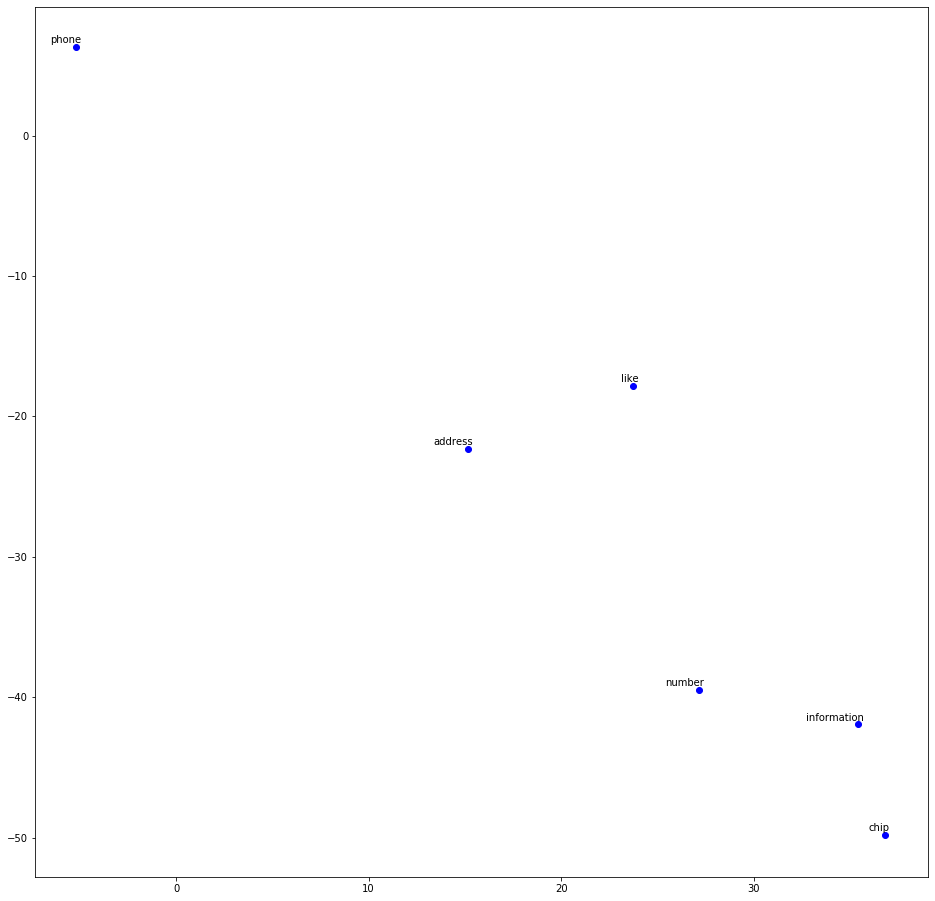

In [665]:
x1 = []
y1 = []
x2 = []
y2 = []

for (value,label) in zip(new_values, labels):
    if label in document1:
        x1.append(value[0])
        y1.append(value[1])    
    if label in document2:
        x2.append(value[0])
        y2.append(value[1])
    
plt.figure(figsize=(16, 16)) 
for i in range(len(x1)):
    plt.scatter(x1[i],y1[i], c = 'blue')
    plt.annotate(document1[i],
                     xy=(x1[i], y1[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    
for i in range(len(x2)):
    plt.scatter(x2[i],y2[i], c = 'red')
    plt.annotate(document2[i],
                     xy=(x2[i], y2[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
plt.show()

In [359]:
sample_id = 1
distance_matrix = wmd_dist
k_neighbors = 10
print(data_whole['target'][sample_id])
neighbours = get_k_neighbors_classes(sample_id, distance_matrix, k_neighbors,
                                     ascending_metric = True)
print(neighbours)
new_class = predict_classification(sample_id, distance_matrix, k_neighbors,
                                   ascending_metric = True)
print(new_class)

4
[(3577, 14, 0.006170321757539727), (15115, 1, 0.006949260332259784), (15302, 13, 0.007443101849612163), (2809, 13, 0.007478409082548347), (14059, 7, 0.007635753385929959), (16880, 5, 0.007655736687316005), (10808, 18, 0.007715032351762946), (13652, 16, 0.00775929270378575), (1162, 10, 0.00784716489559162), (8059, 16, 0.008122858377755353)]
13


In [309]:
# Initialize WmdSimilarity.
from gensim.similarities import WmdSimilarity

In [315]:
instance_sim = WmdSimilarity(data_whole['news'], model, k_neighbors)

def predict_classification_WD(test_id, instance_sim, k_neighbors=10):
    # A query is simply a "look-up" in the similarity class.
    neighbors = instance_sim[data_whole['news'][test_id]]
    neighbors_classes = [data_whole.loc[idx]['target'] for (idx, _) in neighbors]
    prediction = max(set(neighbors_classes), key=neighbors_classes.count)
    return (neighbors ,prediction)

test_id = 1

predict_classification_WD(test_id, instance_sim)

([(1, 1.0),
  (1121, 0.9926263046021048),
  (13135, 0.9921361014006116),
  (5203, 0.9914751898679606),
  (17189, 0.9911330441884842),
  (6674, 0.9910620810243465),
  (10737, 0.9910407122131452),
  (9890, 0.9909468954653897),
  (889, 0.990751873934659),
  (1798, 0.990750040047811)],
 4)

In [314]:
data_whole['target'][test_id]

4

In [ ]:
predicted_labls =[]
for i, _ in tqdm(data_whole.iterrows()):
    predicted_labls.append(predict_classification_WD(i, instance_sim))

In [ ]:
cm = metrics.confusion_matrix(data['target'], predicted_labls)
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names,
                      clusters = cluster_names,
                      title = 'Confusion matrix after LSA without normalization')